# Import

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import os
import re
import shutil
import sys
import ipywidgets
from scipy import stats
from os import listdir
from textwrap import wrap
import statistics
from sklearn.metrics import r2_score
#from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
AVAIL_GPUS = torch.cuda.device_count()
print(AVAIL_GPUS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# utility function for converting csv to xslx:

#Convert input .csv files (annual_growth) to .xlsx
# dir is input directory
dir = 'tax_test/inputs'
# dir = 'COPPER5_CapCost_CTax_PopGrowth_all_false_validation/inputs'
CSV_Files = [file for file in listdir(dir) if file.endswith('.csv') and file.startswith('annual_growth')]
for i in CSV_Files:
    path = os.path.join(dir, i)
    filename = os. path. splitext(i)[0]
    info = pd.read_csv(path)
    info.to_excel ('%s/%s.xlsx' %(dir,filename), index = None, header=True)
    # os.remove(path)

# Dataset Class

In [2]:
# Remove Nan and replcae with mean
def preprocess(data, idx_list):
    tmp_data = np.asarray(data)
    tmp_idx_list = idx_list.copy()
    check = np.isnan(tmp_data).all(axis=0)
    ind =  np.where(check == True)[0]
    tmp_data = np.delete(tmp_data,ind,axis=1)
    for j in sorted(ind, reverse=True):
        del tmp_idx_list[int(j)]
        
#     Modify NaN values (missing values).
    mean_vals = np.nanmean(tmp_data, axis=0)
    inds = np.where(np.isnan(tmp_data))
    tmp_data[inds] = np.take(mean_vals, inds[1])
    return (tmp_data, tmp_idx_list)

def removeOutliers(in_data,out_data,zscore = 5):
    tmp_in_data = np.asarray(in_data)
    tmp_out_data = np.copy(out_data)
    ind = np.where(np.abs(tmp_out_data) > zscore)
    tmp_out_data = np.delete(tmp_out_data,np.unique(ind[0]),axis=0)
    tmp_in_data = np.delete(tmp_in_data,np.unique(ind[0]),axis=0)
    return(tmp_in_data,tmp_out_data)

def stdCleanup(data, idx_list, std_threshold = 1e-3):
    tmp_data = np.asarray(data)
    tmp_idx_list = idx_list.copy()
    ind = np.where(tmp_data.std(axis=0) < std_threshold)[0]
    tmp_data = np.delete(tmp_data,ind,axis=1)
    for j in sorted(ind, reverse=True):
        del tmp_idx_list[int(j)]
    return (tmp_data, tmp_idx_list)

def normalize(data):
    tmp_data = np.asarray(data)
    data_mean = tmp_data.mean(axis=0)
    data_std = tmp_data.std(axis=0)
    
    data_std[data_std < 1e-8] = 1 
    
    ind_min = np.where(tmp_data.min(axis=0) == 0)[0]
    ind_max = np.where(tmp_data.max(axis=0) == 1)[0]
    ind = np.intersect1d(ind_min,ind_max)
    data_mean[ind] = 0
    data_std[ind] = 1
    
    tmp_data = (tmp_data-data_mean)/data_std
    return tmp_data,data_mean,data_std

#plot histogram function
def plot_hist(data,data_idx,plot_name): 
    num_plot = 50
    num_col = 5
    num_row = int(np.ceil(num_plot/num_col))

    num_figures = int(np.ceil((data.shape[1])/num_plot))

    for n in range(num_figures):
        fig, axs = plt.subplots(num_row, num_col, figsize=(20, 20)) # Need to change this depending on the # of outputs. In this case, we have 10 total
        row = 0
        col = 0
        count = 0
        start_index = num_plot*n
        end_index = num_plot*(n+1)
        
        for m in range(start_index, end_index):
            if m> (data.shape[1]-1):
                break

            axs[row, col].hist(data[:,m], bins=50, histtype = 'bar')#, rwidth= 40)
            axs[row, col].grid()
            title = "\n".join(wrap(str(data_idx[m][:]), 120))
            axs[row, col].set_title("\n".join(wrap(str(data_idx[m][:]), 30)), fontsize=10)
            plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=1.4)
            count = count+1
            row = row + 1
            if row == num_row: # Also need to change this depending on # of outputs and desired output structure
                col = col +1
                row = 0
        for ax in axs.flat:
            ax.set(xlabel='bin', ylabel='Frequency')

        plt.savefig("%s/%d.jpg" % (plot_name,n), dpi=100)
    

In [ ]:
#Dataset class for 100 test dataset 

In [3]:
class COPPERDataset(Dataset):

    def __init__(self, input_dir, output_dir):#, transform=None):       
        self.input_dir = input_dir
        self.output_dir = output_dir
        # create list of output folder names
        # count number of data points
        self.output_list = []
        self.run_numbers = []
        for dirname in os.listdir(self.output_dir):
#             numbers = re.findall("(\d+)_outputs_", dirname)
            numbers = re.findall("(\d+)_ct", dirname)
            if not numbers: continue
            
            self.output_list.append(dirname)
            self.run_numbers.append(numbers[0])
            dir = '/content'


        self.input_files_dict = {'Generation_type_data' : [1,'.xlsx', ['max_cap_fact',
                                                                               'min_cap_fact',
                                                                               'ramp_rate_percent', 
                                                                               'efficiency', 
                                                                               'fuel_co2', 
                                                                               'fixed_o_m', 
                                                                               'variable_o_m', 
                                                                               'fuelprice', 
                                                                               'capitalcost']],
                        'COPPER_configuration' : [1,'.xlsx',['Value']],'annual_growth' : [1, '.xlsx', ['2030','2040','2050']]}
        self.output_files_dict = {'carbon_ap': [1,'.xlsx',['2030','2040','2050']],
                    'Total_Generation_ABA': 
                           [1,'.xlsx',['British Columbia.a',
                           'Alberta.a',
                            'Saskatchewan.a',
                            'Manitoba.a',
                            'Ontario.a',
                            'Ontario.b',
                            'Quebec.a',
                            'Quebec.b',
                            'New Brunswick.a',
                            'Newfoundland and Labrador.a',
                            'Newfoundland and Labrador.b',
                            'Nova Scotia.a',
                            'Prince Edward Island.a']],
                    'Canada_gen_outline': [1,'.xlsx',['2030','2040','2050']]}

    def __read_inputs__(self,idx):
        input_dict = {}
        input = torch.empty(0)
        run_number = self.run_numbers[idx]
        for key in self.input_files_dict.keys():
            if key == 'annual_growth':
                input_dict[key]= pd.read_excel('tax_test/inputs/annual_growth.xlsx', header = 0, usecols = self.input_files_dict[key][2],engine='openpyxl')  
                input = torch.cat((input,torch.from_numpy(input_dict[key].values).float().flatten()))
            elif key == 'Generation_type_data':
                input_dict[key]= pd.read_excel('tax_test/inputs/Generation_type_data.xlsx', header = 0, usecols = self.input_files_dict[key][2],engine='openpyxl')  
                input = torch.cat((input,torch.from_numpy(input_dict[key].values).float().flatten()))
                
            else:
                filename = key + '_'+ str(run_number) + self.input_files_dict[key][1] 
                filename_path = os.path.join(self.input_dir, filename)
                # Maybe need adding a line to check if this file or column exist then read
                input_dict[key]= pd.read_excel(filename_path, header = 0, usecols = self.input_files_dict[key][2],engine='openpyxl')
                input = torch.cat((input,torch.from_numpy(input_dict[key].values).float().flatten()))
        filename = 'Generation_type_data.xlsx'
        filename_path = os.path.join(self.input_dir, filename)
        input_dict['Is thermal?']=  pd.read_excel(filename_path, header = 0, usecols = ['Is thermal?'],engine='openpyxl').astype(int) 
        input = torch.cat((input,torch.from_numpy(input_dict['Is thermal?'].values).float().flatten()))
        return input

    def __read_outputs__(self,idx):
        output_dict = {}
        output =  torch.empty(0)
        path = os.path.join(self.output_dir, self.output_list[idx])
        for key in self.output_files_dict.keys():
            filename = key + self.output_files_dict[key][1]
            filename_path = os.path.join(path, filename)
            output_dict[key] = pd.read_excel(filename_path, header = 0, usecols = self.output_files_dict[key][2],engine='openpyxl')
            output = torch.cat((output,torch.from_numpy(output_dict[key].values).float().flatten()))

        return output

    def get_input_index(self,idx):
        input_dict = {}
        input = torch.empty(0)
        run_number = self.run_numbers[idx]
        index = []
        for key in self.input_files_dict.keys():
            if key == 'annual_growth':
                input_dict[key]= pd.read_excel('tax_test/inputs/annual_growth.xlsx', header = 0, usecols = self.input_files_dict[key][2],engine='openpyxl')  
                row,col = input_dict[key].shape
                row_index =  np.repeat(np.matrix(np.arange(row)).transpose(),[col],axis=1)
                col_index = np.repeat(np.matrix(np.arange(col)),[row],axis=0) 
                row_index_flatten = row_index.flatten()
                col_index_flatten = col_index.flatten()
                index=index+[['annual_growth',row_index_flatten.item(i),col_index_flatten.item(i)] for i in range(row_index_flatten.size)]
            elif key == 'Generation_type_data':
                input_dict[key]= pd.read_excel('tax_test/inputs/Generation_type_data.xlsx', header = 0, usecols = self.input_files_dict[key][2],engine='openpyxl')  
                row,col = input_dict[key].shape
                row_index =  np.repeat(np.matrix(np.arange(row)).transpose(),[col],axis=1)
                col_index = np.repeat(np.matrix(np.arange(col)),[row],axis=0) 
                row_index_flatten = row_index.flatten()
                col_index_flatten = col_index.flatten()
                index=index+[['Generation_type_data',row_index_flatten.item(i),col_index_flatten.item(i)] for i in range(row_index_flatten.size)]    
            else:
            
                filename = key + '_'+ str(run_number) + self.input_files_dict[key][1] 
                filename_path = os.path.join(self.input_dir, filename)
                # Maybe need adding a line to check if this file or column exist then read
                input_dict[key]= pd.read_excel(filename_path, header = 0, usecols = self.input_files_dict[key][2],engine='openpyxl')
                row,col = input_dict[key].shape
                row_index =  np.repeat(np.matrix(np.arange(row)).transpose(),[col],axis=1)
                col_index = np.repeat(np.matrix(np.arange(col)),[row],axis=0) 
                row_index_flatten = row_index.flatten()
                col_index_flatten = col_index.flatten()
                index=index+[[filename,row_index_flatten.item(i),col_index_flatten.item(i)] for i in range(row_index_flatten.size)]
        
        filename = 'Generation_type_data.xlsx'
        filename_path = os.path.join(self.input_dir, filename)
        input_dict['Is thermal?']=  pd.read_excel(filename_path, header = 0, usecols = ['Is thermal?'],engine='openpyxl').astype(int) 
        row,col = input_dict['Is thermal?'].shape
        row_index =  np.repeat(np.matrix(np.arange(row)).transpose(),[col],axis=1)
        col_index = np.repeat(np.matrix(np.arange(col)),[row],axis=0) 
        row_index_flatten = row_index.flatten()
        col_index_flatten = col_index.flatten()
        index=index+[[filename,row_index_flatten.item(i),col_index_flatten.item(i)] for i in range(row_index_flatten.size)]
        return index
    
    def get_output_index(self,idx):
        output_dict = {}
        output =  torch.empty(0)
        index = []
        path = os.path.join(self.output_dir, self.output_list[idx])
        for key in self.output_files_dict.keys():
            filename = key + self.output_files_dict[key][1]
            filename_path = os.path.join(path, filename)
            output_dict[key] = pd.read_excel(filename_path, header = 0, usecols = self.output_files_dict[key][2],engine='openpyxl')
            output_dict_rows= pd.read_excel(filename_path, header = 0, usecols = [0],engine='openpyxl')
            output_dict_rows= output_dict_rows.values.tolist()
            headers = output_dict[key].columns
            headers = headers.tolist()
            row,col = output_dict[key].shape
            row_index =  np.repeat(np.matrix(np.arange(row)).transpose(),[col],axis=1)
            col_index = np.repeat(np.matrix(np.arange(col)),[row],axis=0) 
            row_index_flatten = row_index.flatten()
            col_index_flatten = col_index.flatten()
            index=index+[[filename,output_dict_rows[row_index_flatten.item(i)], 
                          headers[col_index_flatten.item(i)]] for i in range(row_index_flatten.size)]
    
        return index

    def __len__(self):
        # return len(self.run_numbers)
        return 1000

    def __getitem__(self, idx):
        input = self.__read_inputs__(idx)
        output = self.__read_outputs__(idx)
        return input,output

In [6]:
# x_raw.shape[1] = 138
ignore_input_idx_list = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 
                         58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 111, 129, 130, 131, 132, 133, 134, 135, 136,
                         137]

In [7]:
# y_raw.shape[1] = 408
ignore_output_idx_list = [0, 1, 2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
                          83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126,
                          127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                          167, 168, 169, 170, 171, 172, 173, 178, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
                          214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
                          255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 295, 297, 299, 300,
                          303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
                          343, 344, 345, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
                          384, 385, 386, 390, 391, 392, 393, 394, 395, 396, 397, 398, 402, 403, 404, 405, 406, 407]

In [4]:
remove_list_x1 = [54, 55, 56, 57, 58, 61, 63, 64, 65, 66, 67, 70, 72, 73, 74, 75, 76, 79, 80]
remove_list_y1 = []

In [5]:
remove_list_x2 = [  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11 , 12,  13,  14,  15,  16,  18,  19,
  20,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,  33,  34,  36,  37,  38,  39,  40,
  41,  42,  43,  45,  46,  47,  48,  49,  50,  51,  52,  54,  55,  57,  58,  60,  61,  62,
  63,  64,  65,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  92, 110,
 111, 112, 113, 114, 115, 116, 117, 118]

remove_list_y2 = [  0 ,  1,   2,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
  45,  46,  47,  48,  49,  50,  52,  53,  55,  56,  61,  63,  66,  69,  70,  71,  72,  73,
  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  88,  89,  90,  92,  93,  95,
  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
 115, 116, 117, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136,
 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 172, 173, 178,
 180, 183, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
 202, 205, 206, 207, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 238, 239, 240, 241, 242, 243, 244, 245,
 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
 282, 283, 284, 286, 287, 288, 289, 290, 297, 300, 303, 304, 305, 306, 307, 308, 309, 310,
 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 326, 329, 330, 331,
 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 348, 350, 355, 356,
 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 369, 370, 371, 372, 373, 374, 375,
 376, 377, 378, 379, 380, 381, 382, 383, 390, 391, 392, 396, 397, 398, 402, 403, 404, 405,
 406]

In [6]:
ignore_y = [ 27,  28,  32,  35,  37,  38,  39,  40,  41,  42,  43,  44,  46,  47,  48,  55,  57,  58,
  59,  60,  61,  62,  63,  64,  66,  71,  74,  77,  78,  79,  81,  82,  83,  84,  85,  86,
  87,  88,  89,  90,  94,  95,  96, 100]

In [ ]:
## Read, Ignore idx, Normalize the new data with the previous mean and std

In [7]:
def remove(data, raw_idx, idx_list):
    tmp_data = np.asarray(data)
    tmp_idx_list = idx_list.copy()
    tmp_data = np.delete(tmp_data,idx_list,axis=1)
    for j in sorted(tmp_idx_list, reverse=True):
        del raw_idx[int(j)]
    return (tmp_data, raw_idx)  

In [8]:
def normalize_new(data, mean, std):
    tmp_data = np.asarray(data)
    data_mean = mean
    data_std = std
    
    data_std[data_std < 1e-8] = 1   
    tmp_data = (tmp_data-data_mean)/data_std
    return tmp_data

In [9]:
# Creat a dataset object
in_dir = 'tax_test/inputs'
out_dir = 'tax_test/outputs'
copperDataset = COPPERDataset(in_dir,out_dir)

In [10]:
input_idx_raw = copperDataset.get_input_index(0)
output_idx_raw = copperDataset.get_output_index(0)

In [11]:
#Read all data on memory

x = []
y = []

for idx in range(100):
    x1, y1 = copperDataset.__getitem__(idx)
    x.append(np.array(x1.reshape(1,len(x1))))
    y.append(np.array(y1.reshape(1,len(y1))))

x_new_raw = np.array(np.vstack(x))
y_new_raw = np.array(np.vstack(y))

In [12]:
for i in range(len(output_idx_raw)):
    output_idx_raw[i].append(i)
    
for i in range(len(input_idx_raw)):
    input_idx_raw[i].append(i)

In [13]:
x_new_raw, input_new_idx = remove(x_new_raw, input_idx_raw, remove_list_x1 )
y_new_raw, output_new_idx = remove(y_new_raw, output_idx_raw, remove_list_y1 )

In [14]:
print(len(input_new_idx))

119


In [15]:
x_new_raw, input_new_idx = remove(x_new_raw, input_idx_raw, remove_list_x2 )
y_new_raw, output_new_idx = remove(y_new_raw, output_idx_raw, remove_list_y2 )

In [83]:
print(output_idx_raw)

[['carbon_ap.xlsx', ['British Columbia'], '2030', 0], ['carbon_ap.xlsx', ['British Columbia'], '2040', 1], ['carbon_ap.xlsx', ['British Columbia'], '2050', 2], ['carbon_ap.xlsx', ['Alberta'], '2030', 3], ['carbon_ap.xlsx', ['Alberta'], '2040', 4], ['carbon_ap.xlsx', ['Alberta'], '2050', 5], ['carbon_ap.xlsx', ['Saskatchewan'], '2030', 6], ['carbon_ap.xlsx', ['Saskatchewan'], '2040', 7], ['carbon_ap.xlsx', ['Saskatchewan'], '2050', 8], ['carbon_ap.xlsx', ['Manitoba'], '2030', 9], ['carbon_ap.xlsx', ['Manitoba'], '2040', 10], ['carbon_ap.xlsx', ['Manitoba'], '2050', 11], ['carbon_ap.xlsx', ['Ontario'], '2030', 12], ['carbon_ap.xlsx', ['Ontario'], '2040', 13], ['carbon_ap.xlsx', ['Ontario'], '2050', 14], ['carbon_ap.xlsx', ['Quebec'], '2030', 15], ['carbon_ap.xlsx', ['Quebec'], '2040', 16], ['carbon_ap.xlsx', ['Quebec'], '2050', 17], ['carbon_ap.xlsx', ['New Brunswick'], '2030', 18], ['carbon_ap.xlsx', ['New Brunswick'], '2040', 19], ['carbon_ap.xlsx', ['New Brunswick'], '2050', 20], ['ca

In [91]:
#Normalize carbontax column

x_new_n = (x_new_raw[:,85] - 500.075012207031)/122.888595581055

In [40]:
print(input_new_idx_s)

[['Generation_type_data', 0, 0, 0], ['Generation_type_data', 0, 1, 1], ['Generation_type_data', 0, 2, 2], ['Generation_type_data', 0, 3, 3], ['Generation_type_data', 0, 4, 4], ['Generation_type_data', 0, 5, 5], ['Generation_type_data', 0, 6, 6], ['Generation_type_data', 0, 7, 7], ['Generation_type_data', 0, 8, 8], ['Generation_type_data', 1, 0, 9], ['Generation_type_data', 1, 1, 10], ['Generation_type_data', 1, 2, 11], ['Generation_type_data', 1, 3, 12], ['Generation_type_data', 1, 4, 13], ['Generation_type_data', 1, 5, 14], ['Generation_type_data', 1, 6, 15], ['Generation_type_data', 1, 7, 16], ['Generation_type_data', 1, 8, 17], ['Generation_type_data', 2, 0, 18], ['Generation_type_data', 2, 1, 19], ['Generation_type_data', 2, 2, 20], ['Generation_type_data', 2, 3, 21], ['Generation_type_data', 2, 4, 22], ['Generation_type_data', 2, 5, 23], ['Generation_type_data', 2, 6, 24], ['Generation_type_data', 2, 7, 25], ['Generation_type_data', 2, 8, 26], ['Generation_type_data', 3, 0, 27], [

In [16]:
#normalize

mean_x = pd.read_excel('Mean_std_f18.xlsx', header = 0, usecols = ['mean_x'], engine='openpyxl').transpose()
std_x = pd.read_excel('Mean_std_f18.xlsx', header = 0, usecols = ['std_x'],engine='openpyxl').transpose()
mean_y = pd.read_excel('Mean_std_f18.xlsx', header = 0, usecols = ['mean_y'],engine='openpyxl').transpose()
std_y = pd.read_excel('Mean_std_f18.xlsx', header = 0, usecols = ['std_y'],engine='openpyxl').transpose()

In [17]:
mean_x = np.array(mean_x)[:,0:39]
std_x = np.array(std_x)[:,0:39]
mean_y =np.array(mean_y)
std_y =np.array(std_y)

In [18]:
x_new = normalize_new(x_new_raw, mean_x, std_x)
y_new = normalize_new(y_new_raw, mean_y, std_y)

In [19]:
y_new, output_new_idx = remove(y_new, output_new_idx, ignore_y )

In [20]:
print(output_new_idx[9])

['carbon_ap.xlsx', ['Ontario'], '2030', 12]


In [21]:
print(x_new[:,9])

[ 0.09075489 -2.67901853  1.79609212 -2.31562053  0.22246076  2.91853546
 -1.97197188 -0.07407644  0.38059274 -0.85647175 -0.24221211 -2.70201227
 -1.54273273 -0.91948559 -0.73744016  0.27713973 -2.32451155  2.30798024
 -0.19259174 -1.66049458  2.3047052  -2.09352407  1.2710909  -1.89151223
 -1.85812281  0.24719347  2.80812955 -0.90589097 -0.54706308 -2.07016764
 -1.62041798  1.19536502  2.35931811  2.32586933 -2.98042398  0.93480962
  1.95834548  0.66025357  1.41314963 -0.18684948  1.33933941  0.44963394
  0.10087232 -2.32483476  0.28273423  0.37427062 -1.83290088  0.73812308
 -2.11995328 -0.98887545 -2.03994312  2.65347576 -0.44592505 -2.93093633
 -2.98344224 -2.90726489  0.63474954 -0.54348134 -2.50623986 -0.87556228
  2.98230449 -2.32831555 -0.22724097  2.09865096  1.14544962 -0.24837803
 -0.6048152   2.08689725 -1.1685833   1.46010288  0.79168156 -1.9856559
  2.34519925 -1.29749987  0.3082472   1.05445162  2.01428946  1.35742517
  1.05681527  1.10367316  2.61464853  1.85292117 -0.

In [127]:
# df=pd.read_csv('CTax.csv', sep=',',header=None)
# z1 = df.values

In [109]:
s = 1

In [225]:
q = 46

Text(0.5, 1.0, "['Total_Generation_ABA.xlsx', ['gas'], 'Quebec.a', 296]")

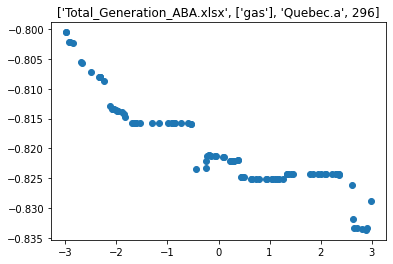

In [226]:
#Plot only one output by changong only one input
 
plt.scatter(x_new[:,9], y_new[:, q]) 
plt.title(output_new_idx[q])
# plt.ylim(-s, s)

Text(0.5, 1.0, "['Total_Generation_ABA.xlsx', ['gas'], 'Quebec.a', 296]")

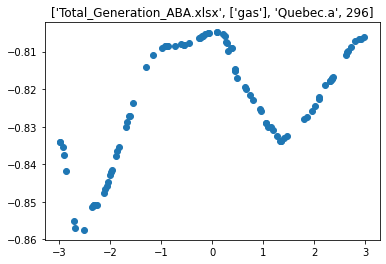

In [227]:
torch.manual_seed(0)
new_model.eval()
x_new_torch = torch.FloatTensor(x_new)
with torch.no_grad():
    y_new_torch = new_model (x_new_torch)   
plt.scatter(x_new_torch[:,9], y_new_torch[:, q]) 
plt.title(output_new_idx[q])
# plt.ylim(-s, s)

In [25]:
class block_1d(pl.LightningModule):
    def __init__(self,in_dim,out_dim,activation=nn.ReLU,dropout = 0.5):
#         self.learning_rate = lr
        super(block_1d, self).__init__()
        self.block = nn.Sequential(
            #nn.BatchNorm1d(in_dim),
#             nn.Dropout(dropout),
            nn.Linear(in_dim,out_dim, bias=True),
#             nn.Linear(in_dim,out_dim),
            activation(),
        )

    def forward(self, x):
        out = self.block(x)
        return out
###############################################################################
class res_block_1d(pl.LightningModule):
    def __init__(self, in_dim, out_dim, activation=nn.ReLU,dropout = 0.5):
        super(res_block_1d, self).__init__()
        self.activation = activation()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_dim),
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim, bias=True),
            activation(),
            nn.BatchNorm1d(out_dim),
            nn.Dropout(dropout),
            nn.Linear(out_dim, out_dim, bias=True),
            activation(),
        )

    def forward(self, x):
#         out = self.activation(self.block(x) + x)
        out = self.block(x) + x
        return out
################################################################################  
class resnet(pl.LightningModule):
    def __init__(self, in_dim, out_dim, layers):
        #layers: list of layer_spec
        #layer_spec: list of [block_type, block dimenssion, block activation, dropout]
        super(resnet, self).__init__()
        self.loss = nn.MSELoss()
        self.num_layers = len(layers)+1
        for index in range(self.num_layers):
            if index == 0 :
                setattr(self, "layer_" + str(index), layers[index][0](in_dim, layers[index][1], layers[index][2],layers[index][3]))
            elif index == self.num_layers-1:
                setattr(self, "layer_" + str(index), nn.Linear(layers[index-1][1], out_dim))
            else:
                setattr(self, "layer_" + str(index), layers[index][0](layers[index-1][1], layers[index][1],layers[index][2],layers[index][3]))
    
    def forward(self, x):
        for index in range(self.num_layers):
            x = getattr(self, "layer_" + str(index))(x)
        return x
###################################################################################    
    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                   batch_size=batch_size,
                                                   #sampler=train_sampler,
                                                   drop_last = False,
                                                   shuffle=True,
                                                   num_workers=1,
                                                   pin_memory = True)
        return train_loader

    def val_dataloader(self):
        validation_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                                        batch_size=batch_size,
                                                        #sampler=valid_sampler,
                                                        drop_last = False,
                                                        shuffle=True,
                                                        num_workers=1,
                                                        pin_memory = True)
        return validation_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                                  batch_size=batch_size,
                                                  #sampler=test_sampler,
                                                  drop_last = False, 
                                                  shuffle=False,
                                                  num_workers=1,
                                                  pin_memory = False)
        return test_loader   
#################################################################################    
    def training_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log('train_loss_step', loss)#,prog_bar=True)
        return {'loss': loss}

    def training_step_end(self, outputs):
        return outputs
    
    def training_epoch_end(self, outputs) -> None:
        self.log('train_loss_epoch',torch.stack([x['loss'] for x in outputs]).mean())
        
    ########################################################    
        
    def validation_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log('val_loss_step', loss)#, prog_bar=True)
        return {'val_loss':loss}
    

    def validation_step_end(self, outputs):
        return outputs

    def validation_epoch_end(self,outputs)->None:
        self.log('val_loss_epoch',torch.stack([x['val_loss'] for x in outputs]).mean())
        
    ########################################################
  
    def test_step(self, batch, batch_idx):
        data, target = batch
        preds = self(data)
        loss = self.loss(preds, target)
        self.log("test_loss", loss)#, prog_bar=True)
        return {'test_loss':loss}

    def test_epoch_end(self,outputs)->None:
        torch.stack([x['test_loss'] for x in outputs]).mean()

    ########################################################

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr= 1e-3)
        return optimizer

In [26]:
# Load saved model 
layers = [[block_1d,128,nn.ReLU,0]]
dim_output = 57
dim_input = 39
num_blocks = 8

for i in range(num_blocks):
    layers.append([res_block_1d,128,nn.ReLU,0.2])  
 
new_model = resnet.load_from_checkpoint("Model_Jan8.ckpt", in_dim = dim_input, out_dim = dim_output, layers = layers )

In [86]:
x_train_new[1,:]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -2.6790,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [ ]:
np.sort(y_new[:,13]

In [128]:
my_data = np.genfromtxt('CTax.csv', delimiter = ',')

In [129]:
print(np.sort(my_data))

[-2.98344205 -2.98042382 -2.9309361  -2.90726471 -2.85863456 -2.70201204
 -2.67901829 -2.5062397  -2.34682271 -2.32831535 -2.32483461 -2.3245114
 -2.31562037 -2.25395686 -2.11995312 -2.09352387 -2.07016742 -2.039943
 -2.00489411 -1.98565575 -1.97197177 -1.89151197 -1.85812266 -1.83290062
 -1.68832458 -1.66049433 -1.62041791 -1.61791539 -1.54273263 -1.29749972
 -1.16858311 -0.9888753  -0.91948536 -0.90589072 -0.87556213 -0.85647159
 -0.73743998 -0.60481514 -0.547063   -0.54348116 -0.44592498 -0.248378
 -0.24221212 -0.22724079 -0.19259169 -0.18684936 -0.14888554 -0.07407636
 -0.05753286  0.09075502  0.1008724   0.22246072  0.24719369  0.27713986
  0.28273446  0.30824711  0.3742705   0.38059298  0.44963414  0.45306781
  0.45659745  0.49133821  0.63474957  0.66025365  0.73812337  0.79168162
  0.93480984  0.95997166  1.05445189  1.05681524  1.10367308  1.14544969
  1.19536518  1.27109094  1.33933946  1.35022918  1.35742533  1.41314945
  1.4601027   1.79609235  1.85292104  1.95834547  2.0142

In [123]:
# x_new[:,9] = np.sort(x_new[:,9])

In [124]:
print(x_new[:,9])

[-2.98344224 -2.98042398 -2.93093633 -2.90726489 -2.85863475 -2.70201227
 -2.67901853 -2.50623986 -2.34682287 -2.32831555 -2.32483476 -2.32451155
 -2.31562053 -2.25395701 -2.11995328 -2.09352407 -2.07016764 -2.03994312
 -2.00489432 -1.9856559  -1.97197188 -1.89151223 -1.85812281 -1.83290088
 -1.68832478 -1.66049458 -1.62041798 -1.61791551 -1.54273273 -1.29749987
 -1.1685833  -0.98887545 -0.91948559 -0.90589097 -0.87556228 -0.85647175
 -0.73744016 -0.6048152  -0.54706308 -0.54348134 -0.44592505 -0.24837803
 -0.24221211 -0.22724097 -0.19259174 -0.18684948 -0.14888571 -0.07407644
 -0.05753308  0.09075489  0.10087232  0.22246076  0.24719347  0.27713973
  0.28273423  0.3082472   0.37427062  0.38059274  0.44963394  0.45306792
  0.45659726  0.49133788  0.63474954  0.66025357  0.73812308  0.79168156
  0.93480962  0.95997145  1.05445162  1.05681527  1.10367316  1.14544962
  1.19536502  1.2710909   1.33933941  1.35022891  1.35742517  1.41314963
  1.46010288  1.79609212  1.85292117  1.95834548  2

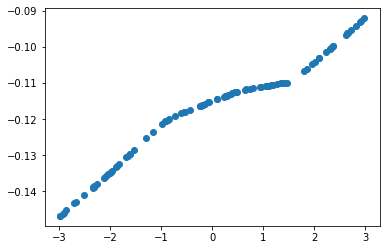

In [114]:
 plt.scatter(x_new2[:,9], y_new2[:,42])
# plt.title(y_train_idx[0])